## More text classification tasks, BERT fine-tuning, and model analysis

This notebook contains a couple more examples of text classification tasks, in addition to those shown in the lesson notebooks, that involve fine-tuning a pre-trained BERT model. They each involve some sort of binary or categorical labels, not text generation as the output. But the problem structure is slightly different for each task.

We'll try fine-tuning a couple different BERT models for each task, so that we can also include some of the basic types of analysis we'd expect to see in your projects. We not only want to look at a common overall evaluation metric to see which model works better, but try to understand the differences in the models' predictions to figure out why.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2024-summer-main/blob/master/materials/model_analysis/more_bert_tasks_and_model_analysis.ipynb)

In [ ]:
!pip install -q transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 15.9 MB/s eta 0:00:00


In [ ]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from transformers import AutoTokenizer, TFAutoModel
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
# Mount drive for saving model checkpoints, and for loading Task 2 data below

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Task 1: GLUE MRPC (Microsoft Research Paraphrase Corpus)

This dataset has pairs of sentences with labels indicating whether the two sentences are equivalent (i.e. they mean the same thing) or not. [GLUE dataset from tensorflow](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc). Code for using the data is based on [this code example here](https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert).

In [ ]:
mrpc, mrpc_info = tfds.load('glue/mrpc', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3668 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/2.0.0.incomplete9UQ6J9/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/408 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/2.0.0.incomplete9UQ6J9/glue-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/1725 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/2.0.0.incomplete9UQ6J9/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# The data comes pre-split
mrpc

{Split('train'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 Split('test'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>}

In [ ]:
# The data includes pairs of sentences with a label for each
mrpc_info.features

FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=string),
    'sentence2': Text(shape=(), dtype=string),
})

In [ ]:
# Here are the labels
mrpc_info.features['label'].names

['not_equivalent', 'equivalent']

In [ ]:
# There are 3668 training examples and 408 validation examples
mrpc_train_data = next(iter(mrpc['train'].batch(3668)))
mrpc_valid_data = next(iter(mrpc['validation'].batch(408)))

In [ ]:
# Look at the first few examples in the data
for i in range(4):
  print()
  for key, value in mrpc_train_data.items():
      print(f"{key:9s}: {value[i].numpy()}")


idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'

idx      : 1456
label    : 0
sentence1: b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed ."
sentence2: b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete , assuming those businesses aren 't sold ."

idx      : 3017
label    : 1
sentence1: b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .'
sentence2: b'Spider-Man , rated PG-13 , snatched $ 114.7 million in its first weekend and went on to take in $ 403.7 million .'

idx      : 2896
label    : 1
sentence1: b"The 2002 second quarter results don 't include figures from our friends at Compaq ."
sentence2: b'The year-ago numbers do not in

#### Models

For both tasks, we'll use a BERT-style model called [DistilRoBERTa](https://huggingface.co/distilroberta-base). It's a based on RoBERTa, a popular variant of BERT with a slightly different pre-training task and other tweaks. And the "Distil" part means it's smaller model than BERT base, with only six transformer blocks instead of 12.

When we want to test a particular hypothesis (e.g. does fine-tuning on a related dataset help with our main task), it's useful to hold other factors constant (e.g. the model architecture and size) so that we know what the main difference is that is driving any difference in performance we observe. It could also be useful to compare different architectures or model sizes, but we'd want to make an isolated comparison for each of those factors. In this notebook, we'll stick with DistilRoBERTa models, and compare versions that have been fine-tuned on different datasets that might be related to our main tasks.

We'll use the DistilRoBERTa base model as one of the models for each task. For the MRPC paraphrase task, we'll compare the base model to a version that's been fine-tuned on a natural language inference (NLI) dataset. NLI is conceptually similar to the paraphrase task we're focused on, since it involves pairs of sentences labeled with whether the first sentence entails the second (i.e. whether they have factually consistent information).

Using a model that has already been trained on a similar task might help the model learn our task more effectively, even with a fairly small dataset for our main task.

In [ ]:
mrpc_bert_model_names = ['distilroberta-base',
                         'matekadlicsko/distilroberta-nli']
mrpc_tokenizers = [AutoTokenizer.from_pretrained(bert_model_name)
                   for bert_model_name in mrpc_bert_model_names]
mrpc_bert_models = [TFAutoModel.from_pretrained(bert_model_name)
                    for bert_model_name in mrpc_bert_model_names]

bert_last_layer_num = 5

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Now we'll write the code to build a keras classification model for the MRPC task, using a pre-trained BERT model and passing the CLS token vector into our classification layer. We'll also define a function to preprocess the MRPC data using the pre-trained BERT tokenizer.

In [ ]:
# Define a function to preprocess the data, which takes a tokenizer and dataset

def preprocess_mrpc(data, tokenizer, max_length):
    sents1 = data['sentence1'].numpy()
    sents2 = data['sentence2'].numpy()

    sentence_pairs = [(sents1[i].decode(), sents2[i].decode())
                          for i in range(sents1.shape[0])]
    encoded = tokenizer.batch_encode_plus(
            sentence_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="tf"
        )

    return [encoded["input_ids"],
            encoded["attention_mask"],
            encoded["token_type_ids"]], data['label']

In [ ]:
# Define the function to build our MRPC model. It takes a pretrained bert model,
# freezes all layers except the last transformer block, then takes the CLS
# token output and passes it to a binary classification layer.

def build_mrpc_model(bert_model, max_length, last_layer_num):
    # Freeze all but the last transformer block of the given bert model
    for w in bert_model.weights:
        if 'layer_._%s' % last_layer_num not in w.name:
            w._trainable = False

    input_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    cls_output = bert_output[0][:, 0, :]

    dropout_output = keras.layers.Dropout(0.3)(cls_output)
    final_output = keras.layers.Dense(1, activation="sigmoid")(dropout_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

We have two models for this task, both of which are small models, along with a small dataset. We'll want to do the same training and evaluation steps on both models, then compare them. Since these models won't take long to train, let's make a loop to preprocess the dataset with each tokenizer, use that data to fine-tune the corresponding model, and save a model checkpoint, so we can do our evaluation and analysis afterwards.



In [ ]:
# It's a good idea to save model checkpoints as you train them.
# Edit this filepath to a place in your own Drive where you want to save them.

checkpoint_dir = 'drive/MyDrive/ISchool/MIDS/266/analysis/model_checkpoints/'

In [ ]:
# Now train each model, and store the trained models in a dict for later analysis

max_length = 128

mrpc_models = {}
for i in range(len(mrpc_bert_model_names)):

    mrpc_train_inputs, mrpc_train_labels = preprocess_mrpc(
        mrpc_train_data, mrpc_tokenizers[i], max_length)
    mrpc_valid_inputs, mrpc_valid_labels = preprocess_mrpc(
        mrpc_valid_data, mrpc_tokenizers[i], max_length)

    sample_weight = np.ones(shape=(len(mrpc_train_labels),))
    for label in range(np.max(mrpc_train_labels)+1):
        class_weight = 1 - np.sum(mrpc_train_labels == label) / len(mrpc_train_labels)
        sample_weight[mrpc_train_labels == label] = class_weight

    checkpoint_prefix = checkpoint_dir + 'mrpc_weights_%s' % mrpc_bert_model_names[i].split('-')[0].split('/')[0]
    checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True
    )

    mrpc_models[mrpc_bert_model_names[i]] = build_mrpc_model(
        mrpc_bert_models[i],
        max_length,
        bert_last_layer_num
    )
    mrpc_models[mrpc_bert_model_names[i]].fit(
        mrpc_train_inputs,
        mrpc_train_labels,
        sample_weight=sample_weight,
        validation_data=[mrpc_valid_inputs, mrpc_valid_labels],
        epochs=4,
        callbacks=[model_checkpoint_callback]
    )

Epoch 1/4


115/115 [==============================] - 42s 230ms/step - loss: 0.2976 - accuracy: 0.6159 - val_loss: 0.6880 - val_accuracy: 0.5319
Epoch 2/4
115/115 [==============================] - 36s 312ms/step - loss: 0.2288 - accuracy: 0.7328 - val_loss: 0.4302 - val_accuracy: 0.7990
Epoch 3/4
115/115 [==============================] - 24s 209ms/step - loss: 0.2049 - accuracy: 0.7767 - val_loss: 0.4366 - val_accuracy: 0.7843
Epoch 4/4
115/115 [==============================] - 24s 212ms/step - loss: 0.1837 - accuracy: 0.8113 - val_loss: 0.4650 - val_accuracy: 0.7721
Epoch 1/4


115/115 [==============================] - 34s 237ms/step - loss: 0.2640 - accuracy: 0.7028 - val_loss: 0.4493 - val_accuracy: 0.7868
Epoch 2/4
115/115 [==============================] - 26s 222ms/step - loss: 0.2219 - accuracy: 0.7658 - val_loss: 0.4238 - val_accuracy: 0.7990
Epoch 3/4
115/115 [==============================] - 26s 229ms/step - loss: 0.2104 - accuracy: 0.7707 - val_loss: 0.4261 - val_accuracy: 0.7917
Epoch 4/4
115/115 [==============================] - 26s 222ms/step - loss: 0.1946 - accuracy: 0.7958 - val_loss: 0.3978 - val_accuracy: 0.8260


The second model (distilroberta-nli) got the highest overall validation accuracy after 4 epochs of training. The first model (distilroberta-base) got close, but then started to overfit.

That said, when the scores are close, it can be difficult to understand which model did better, how much and in what ways, just by looking at overall validation accuracy.

We'll dig into more metrics in the analysis section below. But first let's go through the second task, then we can do the same analysis on both.

### Task 2. Github Bugs Prediction Challenge (Machine Hack)

This dataset contains the titles and bodies of Github discussion posts, labeled with whether the post is about a bug, feature, or question. According to the documentation page, the labels are:
- Bug - 0
- Feature - 1
- Question - 2

The [data is available here](https://www.kaggle.com/datasets/arbazkhan971/github-bugs-prediction-challenge-machine-hack?resource=download). Download the data, upload to Google Drive, and mount your Drive to load the data.

For more exploration, [this blog post](https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/) has similar code on fine-tuning a BERT model for this task and dataset.

In [ ]:
# Edit this filepath to wherever you saved the data in your Drive
filepath = 'drive/MyDrive/ISchool/MIDS/266/data/embold_train.json'

with open(filepath, 'r') as f:
    github_data = json.load(f)

In [ ]:
df_github = pd.DataFrame(github_data)
df_github.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [ ]:
df_github['label'].unique()

array([1, 0, 2])

In [ ]:
len(df_github)

150000

In [ ]:
# Since this is an example notebook, we'll just use 40k training examples and
# 4k validation (always shuffling first). You can explore using more on your own.

df_github = df_github.sample(frac=1)
df_github_train = df_github[0:40000]
df_github_valid = df_github[40000:44000]

#### Models

For the Github task, we'll also start with distilroberta-base as our first model. For comparison, we'll use a model that has been fine-tuned on a SQuAD question answering dataset.

The SQuAD task doesn't seem quite as related to our Github issues classification task, as the NLI task was to the MRPC paraphrase task. I looked for a DistilRoBERTa model that had already been fine-tuned on something like a customer complaints dataset, thinking that might have some similar concepts to Githug bug and issue reports. But DistilRoBERTa isn't quite as commonly used as the larger BERT models, so there weren't as many options in Huggingface. Still, question-answering is somewhat related, since the Github issues often involve questions that users are asking to be solved. We'll see how well it works for our main task.

In [ ]:
github_bert_model_names = ['distilroberta-base',
                           'squirro/distilroberta-base-squad_v2']
github_tokenizers = [AutoTokenizer.from_pretrained(bert_model_name)
                   for bert_model_name in github_bert_model_names]
github_bert_models = [TFAutoModel.from_pretrained(bert_model_name)
                    for bert_model_name in github_bert_model_names]

Now we'll write the code to build a keras classification model for the Github task, using a pre-trained BERT model and passing the CLS token vector into our classification layer. We'll also define a function to preprocess the Github data using the pre-trained BERT tokenizer.

In [ ]:
# Define a function to preprocess the data, which takes a tokenizer and dataset

def preprocess_github(df, tokenizer, max_length):
    titles = df['title'].values
    bodies = df['body'].values

    text_pairs = [(titles[i], bodies[i])
                  for i in range(titles.shape[0])]
    encoded = tokenizer.batch_encode_plus(
            text_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="tf"
        )

    return [encoded["input_ids"],
            encoded["attention_mask"],
            encoded["token_type_ids"]], df['label'].values

In [ ]:
# Define the function to build our Github model. It takes a pretrained bert model,
# freezes all layers except the last transformer block, then takes the CLS
# token output and passes it to a binary classification layer.

def build_github_model(bert_model, max_length, last_layer_num=11):
    # Freeze all but layer_11 and pooler layers
    for w in bert_model.weights:
        if 'layer_._%d' % last_layer_num not in w.name:
            w._trainable = False

    input_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    cls_output = bert_output[0][:, 0, :]

    dropout_output = keras.layers.Dropout(0.3)(cls_output)
    final_output = keras.layers.Dense(3, activation="softmax")(dropout_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Same as with the MRPC task, for the Github task we'll make a loop to preprocess the dataset with each tokenizer, use that data to fine-tune the corresponding model, and save a model checkpoint, so we can do our evaluation and analysis afterwards.

In [ ]:
# Now train each model, and store the trained models in a dict for later analysis

max_length = 128

github_models = {}
for i in range(len(github_bert_model_names)):

    github_train_inputs, github_train_labels = preprocess_github(
        df_github_train, github_tokenizers[i], max_length)
    github_valid_inputs, github_valid_labels = preprocess_github(
        df_github_valid, github_tokenizers[i], max_length)

    sample_weight = np.ones(shape=(len(github_train_labels),))
    for label in range(np.max(github_train_labels)+1):
        class_weight = 1 - np.sum(github_train_labels == label) / len(github_train_labels)
        sample_weight[github_train_labels == label] = class_weight

    checkpoint_prefix = checkpoint_dir + 'github_weights_%s' % github_bert_model_names[i].split('-')[0].split('/')[0]
    checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True
    )

    github_models[github_bert_model_names[i]] = build_github_model(
        github_bert_models[i],
        max_length,
        bert_last_layer_num
    )
    github_models[github_bert_model_names[i]].fit(
        github_train_inputs,
        github_train_labels,
        sample_weight=sample_weight,
        validation_data=[github_valid_inputs, github_valid_labels],
        epochs=2,
        callbacks=[model_checkpoint_callback]
    )

Epoch 1/2


1250/1250 [==============================] - 250s 195ms/step - loss: 0.3663 - accuracy: 0.7766 - val_loss: 0.5966 - val_accuracy: 0.7592
Epoch 2/2
1250/1250 [==============================] - 256s 205ms/step - loss: 0.3271 - accuracy: 0.8030 - val_loss: 0.5023 - val_accuracy: 0.8087
Epoch 1/2


1250/1250 [==============================] - 256s 202ms/step - loss: 0.4216 - accuracy: 0.7234 - val_loss: 0.5512 - val_accuracy: 0.7918
Epoch 2/2
1250/1250 [==============================] - 252s 201ms/step - loss: 0.3543 - accuracy: 0.7846 - val_loss: 0.5628 - val_accuracy: 0.7820


It looks like in this case, distilroberta-base might have worked better than the SQuAD fine-tuned model. But again, the validation accuracy numbers are close, so we should dive in further to try to understand more about when and/or why one model works better than another for this task.

### Breaking Down Evaluation Metrics

Does the validation accuracy shown above give us enough info to simply pick a winning model? Is there more that we can try to understand about which model works better under what conditions, or what types of errors each one is making, so that we can learn how to use them and try to further improve them?

For instance, is one model missing more bugs or features than the other (in the Github data)? Is one over- or under-predicting paraphrase equivalence (in the MRPC data)? A good place to start is to look at precision and recall by label class, as well as a confusion matrix. We'll use the validation data for each task to do so.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

distilroberta-base
13/13 [==============================] - 4s 132ms/step
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       129
           1       0.86      0.79      0.83       279

    accuracy                           0.77       408
   macro avg       0.74      0.76      0.75       408
weighted avg       0.79      0.77      0.78       408

matekadlicsko/distilroberta-nli
13/13 [==============================] - 3s 134ms/step
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       129
           1       0.91      0.82      0.87       279

    accuracy                           0.83       408
   macro avg       0.80      0.83      0.81       408
weighted avg       0.84      0.83      0.83       408



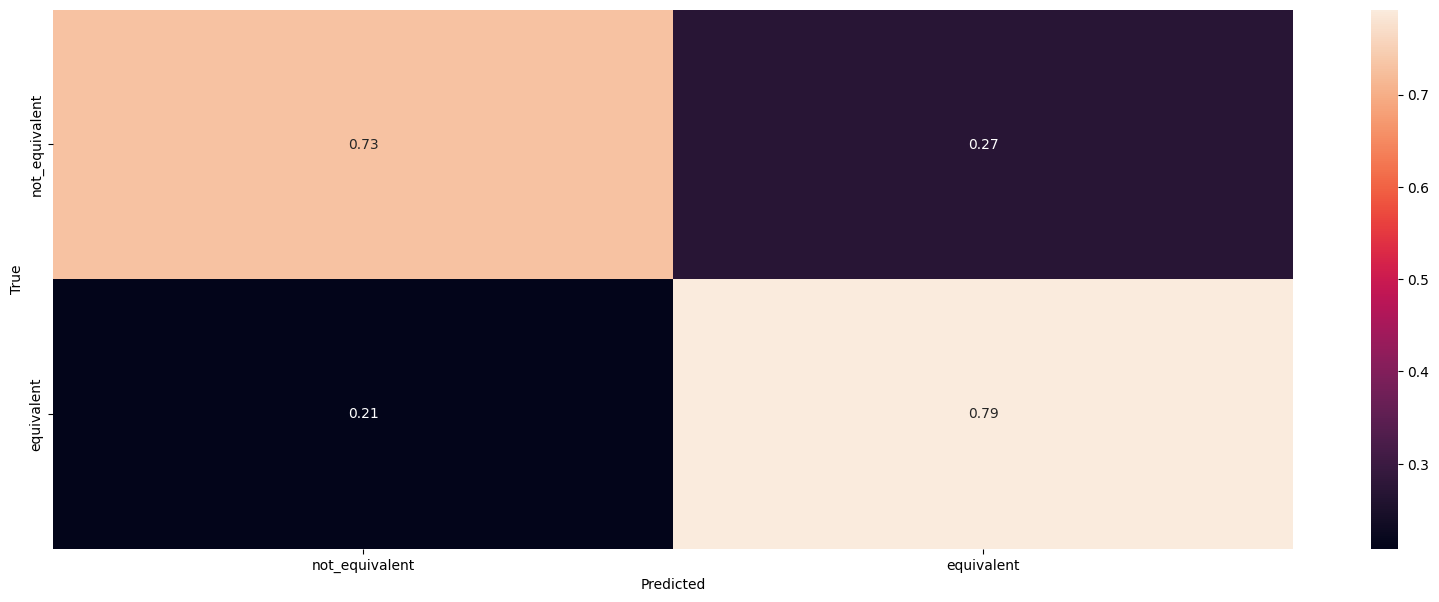

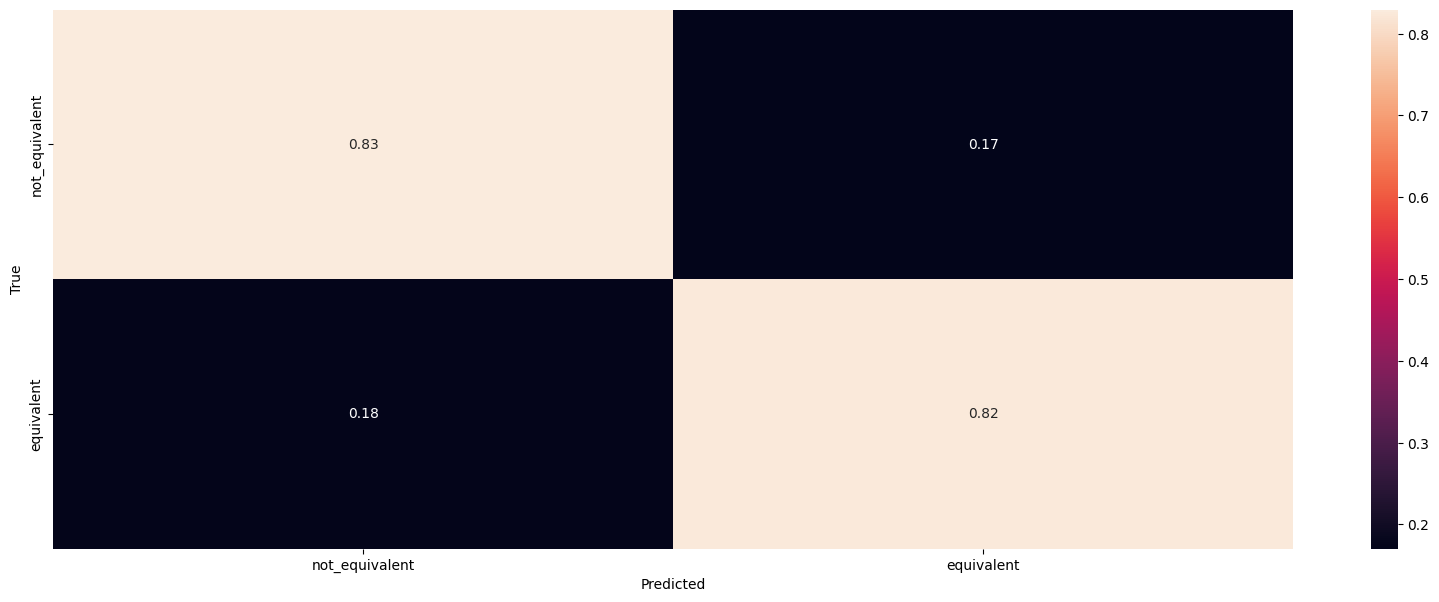

In [ ]:
# Print classification report and confusion matrix for each model, for MRPC task.

mrpc_label_names = mrpc_info.features['label'].names

mrpc_wrong_guesses = {}  # Save indices of wrong guesses so we can look at them later

for i in range(len(mrpc_bert_model_names)):
    print(mrpc_bert_model_names[i])

    mrpc_valid_inputs, mrpc_valid_labels = preprocess_mrpc(
        mrpc_valid_data, mrpc_tokenizers[i], max_length)

    mrpc_y_probs = mrpc_models[mrpc_bert_model_names[i]].predict(mrpc_valid_inputs)
    mrpc_y_pred = np.squeeze(mrpc_y_probs >= 0.5)
    print(classification_report(mrpc_valid_labels, mrpc_y_pred))

    plot_confusion_matrix(mrpc_valid_labels, mrpc_y_pred, mrpc_label_names)

    mrpc_wrong_guesses[mrpc_bert_model_names[i]] = np.where(mrpc_valid_labels != mrpc_y_pred)

For the MRPC task, the second model (distilroberta-nli) does appear to perform better across both categories than the first model (distilroberta-base). It also appears to handle the imbalanced data a little better.

The first model slightly overpredicts the majority class, while the second model is more balanced. All precision and recall scores are higher in the second model, but the largest difference is how much it increased recall of the minority class over the first model.

This does seem to support our hypothesis that the second model's prior training on an NLI dataset helped it do well on our MRPC paraphrase task. It's not perfect, though. So we should still take a look at some examples that the model is still getting wrong (below).

But first, let's print the same breakdown of evaluation metrics and confusion matrix for the second task, the Github issues.

distilroberta-base
125/125 [==============================] - 19s 143ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1760
           1       0.82      0.85      0.84      1883
           2       0.66      0.35      0.46       357

    accuracy                           0.81      4000
   macro avg       0.76      0.69      0.71      4000
weighted avg       0.80      0.81      0.80      4000

squirro/distilroberta-base-squad_v2
125/125 [==============================] - 19s 145ms/step
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1760
           1       0.82      0.82      0.82      1883
           2       0.44      0.59      0.51       357

    accuracy                           0.78      4000
   macro avg       0.70      0.73      0.71      4000
weighted avg       0.79      0.78      0.79      4000



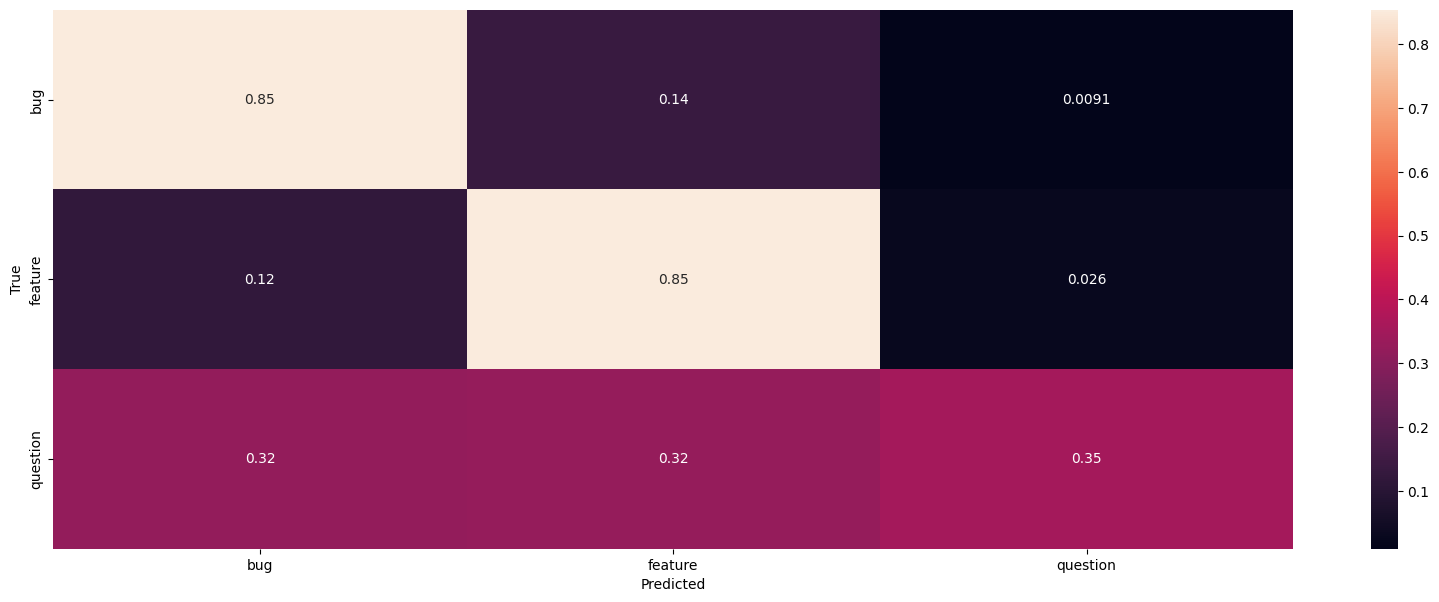

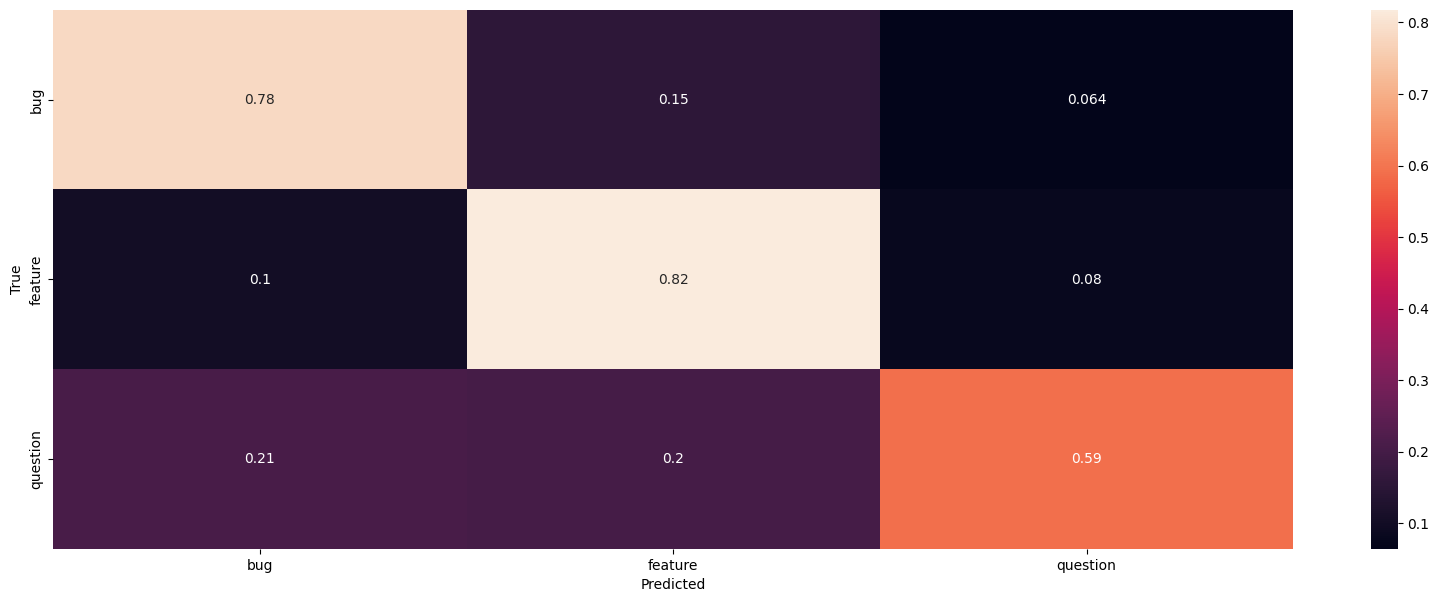

In [ ]:
# Print classification report and confusion matrix for each model, for Github issues task.

github_label_names = ['bug', 'feature', 'question']

github_wrong_guesses = {}

for i in range(len(github_bert_model_names)):
    print(github_bert_model_names[i])

    github_valid_inputs, github_valid_labels = preprocess_github(
        df_github_valid, github_tokenizers[i], max_length)

    github_y_probs = github_models[github_bert_model_names[i]].predict(github_valid_inputs)
    github_y_pred = np.argmax(github_y_probs, axis=-1)
    print(classification_report(github_valid_labels, github_y_pred))

    plot_confusion_matrix(github_valid_labels, github_y_pred, github_label_names)

    github_wrong_guesses[github_bert_model_names[i]] = np.where(github_valid_labels != github_y_pred)

Here, the break-down is more mixed. The second model (the SQuAD trained one) has a higher macro avg F1 score, but the first model (distilroberta-base) has a higher weighted avg F1 score. This is driven by the difference in category-level performance. The first (base) model has a higher F1 score for both of the first two categories (bugs and features), which are by far the largest categories in the dataset. But the SQuAD trained model has a higher F1 score for the third category (questions), which is a much smaller category.

Hey, that kind of makes sense, right? The questions category is so small, that the general-purpose base model tends to underpredict it. It has especially low recall for that third category, and many question examples are misclassified into both of the other two categories. But the second model, which was specifically trained to understand questions, seems better able to recognize what a question is, even when our main task dataset has very few of them.

This might also be a realization we could have made after we trained and evaluated the first model. Even if we didn't think to use a model fine-tuned on question answering at first, we might think of it after looking at the first model's results. Since the first model is weakest on that third category of questions, and we might not have a way to augment the data to add more Github-style question examples, we might consider trying fine-tuning our model another dataset more focused on question style text in order to help it better recognize questions in the Github dataset.

Let's see if there's anything else we can learn about this model comparison, or further evidence we can use to validate what we think is happening, when we look at the remaining misclassifications directly.

### Inspecting Misclassifications

It's always important to look at actual examples from our validation data, to see what mistakes the model is making. Below, we'll use the indices of the examples each model got wrong. We'll separate them into examples that only one model got wrong but not the other, as well as examples both models got wrong, and print out a sample from each to look at.

In [ ]:
# MRPC: examples that the first model got right and the second got wrong

mrpc_examples_model1_better = [i for i in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[1]])
                               if i not in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[0]])]

for i in mrpc_examples_model1_better[:10]:
    print(mrpc_valid_data['sentence1'][i])
    print(mrpc_valid_data['sentence2'][i])
    print(mrpc_valid_data['label'][i])

tf.Tensor(b"The show 's closure affected third-quarter earnings per share by a penny .", shape=(), dtype=string)
tf.Tensor(b'The company said this impacted earnings by a penny a share .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'Terri Schiavo , 39 , underwent the procedure at the Tampa Bay area hospice where she has been living for several years , said her father , Bob Schindler .', shape=(), dtype=string)
tf.Tensor(b'The tube was removed Wednesday from Terri Schiavo , 39 , at the Tampa Bay-area hospice where she has lived for several years .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'The Hartford shares rose $ 2.88 , or 6.6 percent , to close Monday at $ 46.50 on the New York Stock Exchange .', shape=(), dtype=string)
tf.Tensor(b'Shares of Hartford rose $ 2.88 to $ 46.50 in New York Stock Exchange composite trading .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"Blair 's Foreign Secretary Jack St

In [ ]:
# MRPC: examples that the second model got right and the first got wrong

mrpc_examples_model2_better = [i for i in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[0]])
                               if i not in np.squeeze(mrpc_wrong_guesses[mrpc_bert_model_names[1]])]

for i in mrpc_examples_model2_better[:10]:
    print(mrpc_valid_data['sentence1'][i])
    print(mrpc_valid_data['sentence2'][i])
    print(mrpc_valid_data['label'][i])

tf.Tensor(b'The study , published Monday in the journal Molecular Brain Research , is likely to also apply to humans , its authors said .', shape=(), dtype=string)
tf.Tensor(b'The study , conducted on the brains of developing mice , was being published today in the journal Molecular Brain Research .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Police suspected that Shaichat , 20 , had been abducted either by Palestinians or by Israeli Arabs .', shape=(), dtype=string)
tf.Tensor(b"Nobody claimed responsibility for Schaichat 's death , but police suspect that the 20-year-old soldier was abducted either by Palestinians or Israeli Arabs .", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'About two hours later , his body , wrapped in a blanket , was found dumped a few blocks away .', shape=(), dtype=string)
tf.Tensor(b'Then his body was dumped a few blocks away , found in a driveway on Argyle Road .', shape=(), dtype=string)
tf.Tensor(0, 

In [ ]:
# MRPC: examples that both models got wrong

mrpc_examples_both_wrong = np.intersect1d(mrpc_wrong_guesses[mrpc_bert_model_names[0]],
                                          mrpc_wrong_guesses[mrpc_bert_model_names[1]])

for i in mrpc_examples_both_wrong[:10]:
    print(mrpc_valid_data['sentence1'][i])
    print(mrpc_valid_data['sentence2'][i])
    print(mrpc_valid_data['label'][i])

tf.Tensor(b"The player 's eyes were bloodshot and a blood-alcohol test produced a reading of 0.18 - well above Tennessee 's level of presumed intoxication of 0.10 , the report said .", shape=(), dtype=string)
tf.Tensor(b"He failed a field sobriety test and a blood-alcohol test produced a reading of 0.18 \xe2\x80\x93 well above Tennessee 's level of presumed intoxication of 0.10 , the report said .", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'Its closest living relatives are a family frogs called sooglossidae that are found only in the Seychelles in the Indian Ocean .', shape=(), dtype=string)
tf.Tensor(b'Its closest relative is found in the Seychelles Archipelago , near Madagascar in the Indian Ocean .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'The other inmate fell but Selenski shimmed down the makeshift rope to a second-story roof and used the mattress to scale a razor-wire fence , Fischi said .', shape=(), dtype=string)
tf.

For the first task, I don't see any obvious patterns that stand out when looking at a sample of misclassifications that model 1 got right and model 2 didn't, and vice versa. But it's useful to at least confirm that we aren't missing something important that one of the models might be consistently getting wrong, and that we can easily fix.

Both model 1's and model 2's misclassifications including "equivalent" and "non-equivalent" labeled sentence pairs. And they both cover a variety of topics, so it doesn't look like either model is taking any simple shortcuts, like thinking all sentence pairs about politics are non-equivalent.

Sometimes, differences in model output or predictions are clearest when looking at actual text examples. Sometimes, they're easier to spot through quantitative break-downs. We'll try a few other ways to slice the examples in a bit.

But first, let's look at example misclassifications from the second task as well.

In [ ]:
# Github: examples that the first model got right and the second got wrong

github_examples_model1_better = [i for i in np.squeeze(github_wrong_guesses[github_bert_model_names[1]])
                                 if i not in np.squeeze(github_wrong_guesses[github_bert_model_names[0]])]

for i in github_examples_model1_better[:10]:
    print(df_github_valid['title'].values[i])
    print(df_github_valid['body'].values[i])
    print(df_github_valid['label'].values[i])

after enabling ota dynamically provisioned devices always reconnecting again and again
\r  28482  connecting to qa.blynk.cc:8442\r  29949  ready  ping: 16ms .\r  30429  connecting to qa.blynk.cc:8442\r  45433  connecting to qa.blynk.cc:8442\r  52181  ready  ping: 0ms .\r  52496  connecting to qa.blynk.cc:8442\r  67670  connecting to qa.blynk.cc:8442\r  68135  ready  ping: 2ms .\r  69106  connecting to qa.blynk.cc:8442\r    \r \r turning off ota fixes the issue.\r server only sends  \ ota url\   command with ota enabled.
0
1 ioservice per client may reduce performance.
running too many ioservice threads may kill server performance. we might want to look into creating a ioserver pool that distributes clients out to a fixed number of threads.
1
uses @return instead of @returns
this came up when i ran my eslint check. should be a pretty quick fix.
0
elvis operator with date formatting
i want to use the elvis operator with a date field. the problem is that if i want to format that date, and

In [ ]:
# Github: examples that the second model got right and the first got wrong

github_examples_model2_better = [i for i in np.squeeze(github_wrong_guesses[github_bert_model_names[0]])
                                 if i not in np.squeeze(github_wrong_guesses[github_bert_model_names[1]])]

for i in github_examples_model2_better[:10]:
    print(df_github_valid['title'].values[i])
    print(df_github_valid['body'].values[i])
    print(df_github_valid['label'].values[i])

firing triggers from blackbox containers
from @vinodmut : \r \r what's the right mechanism to fire triggers from a blackbox container? unlike javascript actions, there's no sdk the developer can use.\r \r the simplest option is to use the /triggers api.\r \r this came up in the context of asynchronous results, where the async result is sent in a trigger event.
1
proteins have less peptides than before
some proteins have a lot less peptides mapping to them than before. example: p08238  heat shock protein hsp 90-beta  hs90b_human   used to have 32 peptides, now it only has 10...\r \r  tested by loading only the x! tandem identifications of the example dataset.
0
homepage menu ba has not views
centreon web version  : \r 2.8.15\r   centreon engine version  : \r \r   centreon broker version  : \r \r   os  : \r centos6\r   additional environment details  aws, virtualbox, physical, etc. :  \r vmware10\r \r   question:\r why i login the centrons, homepage menu ba has not views?
2
option to mak

In [ ]:
# Github: examples that both models got wrong

github_examples_both_wrong = np.intersect1d(github_wrong_guesses[github_bert_model_names[0]],
                                            github_wrong_guesses[github_bert_model_names[1]])

for i in github_examples_both_wrong[:10]:
    print(df_github_valid['title'].values[i])
    print(df_github_valid['body'].values[i])
    print(df_github_valid['label'].values[i])

vimfx doesn't enter insert mode when composing e-mail and focusing in message body text area in outlook web access  owa  2010
steps to reproduce:\r \r 1. visit an owa 2010  v. 14  instance and compose a new e-mail.\r 2. focus on the message body text area  bug doesn't happen in other text areas such in the to: and cc: fields .\r \r expected result: vimfx should enter insert mode.\r \r actual result: it doesn't.  keys are still captured by vimfx, resulting in haphazard behaviour such as reloading all tabs when you type \ dear\  as \ ar\  gets captured.\r \r vimfx version: 0.15.0\r firefox version: 46.0.1\r os: ubuntu linux 16.04\r keyboard language: en-uk\r worked before: n/a\r example url s : cannot provide example url as it depends on my work credentials to log in.
1
oconcurrentmodificationexception when try to increment a sequence
orientdb version, operating system, or hardware.\r - v2.0 snapshot    - .18    .17    .16    .15    .14    .13    .12    .11    .10    .9    .8    .7    .6

There's a clearer pattern here, in line with what we saw in the classification report break-down. The examples that model 1 gets right but model 2 does not are dominated by the first two labels (bugs and features). The examples that model 2 gets right and model 1 does not are dominated by the third label (questions).

Looking at the text, it's not always clear to me why an issue was labeled by the human annotators as a question, rather than e.g. a bug report. But many of the examples labeled as questions do seem to at least contain a grammatically phrased question (i.e. a sentence ending in a question mark). Occasionally, an example labeled in one of the other categories also has a question mark, but less often, by the looks of it. That's something we could count up across the dataset, too.

Looking at the text, you can see that the language in the second task is very different from the language used in the first. It's more informal, and there are a lot of first-person pronouns ("I"), on a discussion board like this. The language looks similar in both examples that model 1 did better on and examples that model 2 did better on. (Both sets have first person pronouns, abbreviations, incomplete sentences, some machine output/error message type text, etc.)

So beyond the questions label, it isn't obvious if one model is doing better than the other at understanding that informal style text. But we could try to look for some other quantitative patterns in the examples model 1 did better on, vs. the examples model 2 did better on.

### Text attributes associated with differences in model errors

We might be able to identify patterns with some aggregate summary statistics. Maybe we think we see a potential pattern in the misclassifications, but we aren't sure if that's a consistent difference between the two models.

For instance, in the Github task, we noticed that a lot of the examples model 2 did better on, there's some statement phrased as a question, ending in a question mark. Can we verify that quantitatively? It might not tell us much more than we already know, but it's easy to count.

Let's do this analysis on both tasks, just to see what happens. The two models use different tokenizers, but we're interested in real words and punctuation here. So let's use spaCy to split up the text and apply some filters to it (first just counting up question marks, later we could use other spaCy tags).

In [ ]:
!pip -q install -U spacy

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def pct_qmarks_spacy(text):
    doc = nlp(text)
    return len([tok for tok in doc if tok.text == '?']) / len(doc)

pct_qmarks_spacy('This is a sentence with some stopwords? in it?')

0.181818181818183


In [ ]:
avg_stops_model1_better = np.mean([pct_qmarks_spacy(mrpc_valid_data['sentence1'].numpy()[i].decode()
                                   + mrpc_valid_data['sentence2'].numpy()[i].decode())
                                  for i in mrpc_examples_model1_better])
avg_stops_model2_better = np.mean([pct_qmarks_spacy(mrpc_valid_data['sentence1'].numpy()[i].decode()
                                   + mrpc_valid_data['sentence2'].numpy()[i].decode())
                                  for i in mrpc_examples_model2_better])

print('Avg pct questionmarks in paraphrase sentences when model 1 did better: %.4f' % avg_stops_model1_better)
print('Avg pct questionmarks in paraphrase sentences when model 2 did better: %.4f' % avg_stops_model2_better)

Avg pct questionmarks in paraphrase sentences when model 1 did better: 0.0000
Avg pct questionmarks in paraphrase sentences when model 2 did better: 0.0000


In [ ]:
avg_stops_len_model1_better = np.mean([pct_qmarks_spacy(df_github_valid['title'].values[i]
                                       + df_github_valid['body'].values[i])
                                      for i in github_examples_model1_better])
avg_stops_len_model2_better = np.mean([pct_qmarks_spacy(df_github_valid['title'].values[i]
                                       + df_github_valid['body'].values[i])
                                      for i in github_examples_model2_better])

print('Avg pct questionmarks in github post when model 1 did better: %.4f' % avg_stops_len_model1_better)
print('Avg pct questionmarks in github post when model 2 did better: %.4f' % avg_stops_len_model2_better)

Avg pct questionmarks in github post when model 1 did better: 0.0055
Avg pct questionmarks in github post when model 2 did better: 0.0076


For the Github task, there are definitely more question marks in the examples that model 2 gets right, than in the examples that model 1 gets right. We don't see that pattern in the MRPC task; in fact, the MRPC dataset seems to have no (or almost no) examples with question marks at all. Breaking down the text in a particular way might only make sense for one task and not for others.

Let's try something else, since we've got spaCy loaded. Beyond question marks, did the second model in the Github task learn how to recognize other subtle clues in text that's asking an open-ended question, vs. text that's stating a problem or proposing a solution?

SpaCy can tag a variety of grammatical and semantic features for us, including parts of speech and dependency relations. We might want to look for question-implying words like "what", "where", "how", as well as uncertain words like "if", "any", etc. Let's write a sentence that sounds like someone asking a question, but with no actual question mark, and see what spaCy shows us.

In [ ]:
doc = nlp("I'm not sure what to do here. Wondering if anyone has an idea if this is the right way to do a thing.")

for tok in doc:
  print(tok.text, tok.dep_, tok.pos_)

I nsubj PRON
'm ROOT AUX
not neg PART
sure acomp ADJ
what dobj PRON
to aux PART
do xcomp VERB
here advmod ADV
. punct PUNCT
Wondering ROOT VERB
if mark SCONJ
anyone nsubj PRON
has ccomp VERB
an det DET
idea dobj NOUN
if mark SCONJ
this nsubj PRON
is advcl AUX
the det DET
right amod ADJ
way attr NOUN
to aux PART
do relcl VERB
a det DET
thing dobj NOUN
. punct PUNCT


There seem to be quite a few words marked as pronouns in here (POS tag = "PRON"). "I" and "this" are pronouns, as well as an open-ended personal reference like "anyone". The word "what" is also a pronoun as used here, referring vaguely to something the user is asking for but doesn't know what specifically to call it.

Let's count the percent of tokens in each example text that are tagged as pronouns by spaCy, and see if that percentage is higher in examples that model 1 got right, or in examples that model 2 got right. We can do this again for both tasks, just to see what happens.

In [ ]:
def pct_pronouns(text):
    doc = nlp(text)
    return len([tok for tok in doc if tok.pos_ == 'PRON']) / len(doc)

pct_pronouns('This is a sentence with some stopwords in it.')

0.2

In [ ]:
avg_stops_model1_better = np.mean([pct_pronouns(mrpc_valid_data['sentence1'].numpy()[i].decode()
                                   + mrpc_valid_data['sentence2'].numpy()[i].decode())
                                  for i in mrpc_examples_model1_better])
avg_stops_model2_better = np.mean([pct_pronouns(mrpc_valid_data['sentence1'].numpy()[i].decode()
                                   + mrpc_valid_data['sentence2'].numpy()[i].decode())
                                  for i in mrpc_examples_model2_better])

print('Avg pct pronouns in paraphrase sentences when model 1 did better: %.4f' % avg_stops_model1_better)
print('Avg pct pronouns in paraphrase sentences when model 2 did better: %.4f' % avg_stops_model2_better)

Avg pct pronouns in paraphrase sentences when model 1 did better: 0.0407
Avg pct pronouns in paraphrase sentences when model 2 did better: 0.0260


In [ ]:
avg_stops_len_model1_better = np.mean([pct_pronouns(df_github_valid['title'].values[i]
                                       + df_github_valid['body'].values[i])
                                      for i in github_examples_model1_better])
avg_stops_len_model2_better = np.mean([pct_pronouns(df_github_valid['title'].values[i]
                                       + df_github_valid['body'].values[i])
                                      for i in github_examples_model2_better])

print('Avg pct pronouns in github post when model 1 did better: %.4f' % avg_stops_len_model1_better)
print('Avg pct pronouns in github post when model 2 did better: %.4f' % avg_stops_len_model2_better)

Avg pct pronouns in github post when model 1 did better: 0.0490
Avg pct pronouns in github post when model 2 did better: 0.0480


Unfortunately, for the Github task, the percentage of pronouns seems pretty consistent across examples model 1 got right and examples model 2 got right. So it really seems to be that clear question-phrased text (with a question mark) that model 2 is better able to recognize (because of its SQuAD training). We haven't found other patterns in informal or vaguer text that model 2 is better at understanding than model 1. But there's always more you could try.

However, when looking at the prevalence of pronouns, there's actually a big difference in the first task! The distilbert-base model seems to do better at recognizing paraphrased text when it has a higher rate of pronouns (closer to the pronoun rate in the more informal text in the Github dataset), while the distilbert-nli model seems to do better at recognizing paraphrases when the text has a much lower rate of pronouns.

Could there be a reason for that? Maybe. The distilbert-nli model was better on average at recognizing paraphrases than the base model, because it's already been trained on a natural language inference dataset. But that type of dataset tends to have lots of factual news and historic reference style text, about specific people, places and events. The NLI-trained model probably didn't gain any advantages in recognizing paraphrases in looser, vaguer text. And it might have even lost some of the original base model's general ability to understand the meaning of more abstract text, leading to the base model performing better in classifying the few instances where more pronoun-heavy text does come up in our MRPC dataset.

Is there any other way we can test this?

### Engineered Test Examples

If we have a hypothesis about a specific factor that can change a model's performance, we can try to test that hypothesis by feeding the model specially engineered examples. In particular, we can try to give a model two examples, which are almost the same, but have just this one thing different, and see if that changes the model's prediction.

Let's try that here, with the MRPC task. Our idea is that the NLI-trained model (model 2) might be better at recognizing factual inconsistencies between two sentences that make them not-equivalent, especially when the text involves clearly stated news-style facts. But the base model (model 1) might be better at recognizing inconsistencies in more vague, less factual text.

Let's make two examples, one that involves very specific newsy factual text, and one that involves much vaguer informal text. In both cases, let's make the pair of sentences be mostly about the same thing, but with slight factual inconcistencies. We could first have a pair of sentences about a hurricane, but the level and date of arrival are different. Then let's have a pair of sentences about a more vague looming event, except only one of the sentences says it's a storm, the other says it could be anything.

In [ ]:
test_examples = [
    ["The category 5 hurricane will hit New Orleans at 5 p.m. on January 24.",
     "The hurricane, which is a category 4, will reach New Orleans on February 24 at 5 p.m."],

    ["The thing that's coming, it's a storm, and it's going to be a bad one, and it'll hit soon.",
     "The thing that's coming is going to be bad, it could be anything, but it'll get here soon."]
]

We'll need to modify our preprocessing function, because we aren't using a tensorflow dataset as the input, we just have a list of two examples that are already in the form of sentence pairs. But the structure of the input is otherwise the same as what went into the models for training.

In [ ]:
def preprocess_test_examples(sentence_pairs, tokenizer, max_length):
    encoded = tokenizer.batch_encode_plus(
            sentence_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="tf"
        )

    return [encoded["input_ids"],
            encoded["attention_mask"],
            encoded["token_type_ids"]]

Let's preprocess both pairs of sentences, pass them through both models and get the models' predictions, then compare.

In [ ]:
predictions = []
for i in range(len(mrpc_bert_model_names)):
    print(mrpc_bert_model_names[i])

    test_example_inputs = preprocess_test_examples(
        test_examples, mrpc_tokenizers[i], max_length)

    test_example_probs = mrpc_models[mrpc_bert_model_names[i]].predict(test_example_inputs)
    predictions.append(test_example_probs.squeeze())

for j in range(len(test_examples)):
    print()
    print(test_examples[j][0])
    print(test_examples[j][1])
    for i in range(len(mrpc_bert_model_names)):
        print('Model %d prediction: ' % (i + 1), predictions[i][j])

distilroberta-base
1/1 [==============================] - 0s 60ms/step
matekadlicsko/distilroberta-nli
1/1 [==============================] - 0s 56ms/step

The category 5 hurricane will hit New Orleans at 5 p.m. on January 24.
The hurricane, which is a category 4, will reach New Orleans on February 24 at 5 p.m.
Model 1 prediction:  0.8348511
Model 2 prediction:  0.16717348

The thing that's coming, it's a storm, and it's going to be a bad one, and it'll hit soon.
The thing that's coming is going to be bad, it could be anything, but it'll get here soon.
Model 1 prediction:  0.09156391
Model 2 prediction:  0.5886914


The two models give us very different predictions! And the difference is in line with our hypothesis. Model 2 is very confident in predicting that the first sentence pair is not equivalent (0.09 predicted probability that they're equivalent), but Model 1 seems to think that they are equivalent. Model 2 was able to recognize the specific factual inconsistencies (category 5/4, Jan/Feb), while Model 1 probably gets caught up on the broader similarities (hurricane, New Orleans).

However, the reverse is true for the second sentence pair. Model 1 now recognizes that the two sentences are probably not equivalent, even though they're again very similar in language. There aren't as many specifically named details that are the same (e.g. event or place names) to confuse Model 1, and even though most of the text says similar things, Model 1 seems to recognize that it's not saying exactly the same. Meanwhile, Model 2 mistakenly thinks the sentence pair is probably equivalent. It doesn't seem to recognize the vaguely worded inconsistencies as being clear differences, the way it can recognize differences in more detailed facts.

These are simple examples just to show you how you might think about the results you see when comparing your models, and how you can use your intuition to think through additional metrics or break-downs in your model analysis. Even if one model does better than another overall, understanding that model's remaining weaknesses and how other models can offer gains in specific cases, can help you plan further improvements like adding additional training data or incorporating other related tasks.